- Loaded in source into Ty
- Interdigitated sample
- 0.4mBar oxidation

In [55]:
%matplotlib notebook
import logging

from matplotlib import pyplot as plt
import numpy as np
from numpy import linalg as LA
from matplotlib import cm
import scqubits as scq
from scipy.optimize import curve_fit
from quantum_builder import QuantumBuilder
import ipywidgets
import matplotlib.gridspec as gridspec
import os

plt.style.use('support-files/qubit.mplstyle')

FLUX = float
FLUX_NUMBER = int

cos = np.cos
sin = np.sin
pi = np.pi

fF = 10 ** (-15)
c = 10**(-10) #F/m Capacitance on interface
h = 6.64 * 10**(-34)
e = 1.6 * 10**(-19)
um = 10**(-6)
GHz = 10**(9)
kOhm = 10**3
Rq = 6.484*kOhm
Delta = 3.1*10**(-23) # Superconducting delta
Phi0 = h/(2 * e)
Gauss = 10**(-4) # Gauss to Wb/m²

MY_COLOURS = {
    "DarkBlue": "#104e8b",     # dark blue (DodgerBlue4)
    "DarkRed": "#ed2200",     # dark red (red2)
    "Green": "#9acd32",     
    "Orange": "#ffc125",      # orange,
    "LightBlue": "#68838b",  # light steel blue,
    "Purple": "#6959cd",  # dark purple
    "Pink": "#ffa07a"  # pink salmon
}
CMAPS =  ['viridis', 'plasma', 'inferno', 'magma', 'cividis']
COLORMAP_01 = ["#79cdcd", "#eead0e", "#9a37ff", "#00ee76"]
COLORMAP_12 = plt.get_cmap('Reds')
COLORMAP_ENERGY = plt.get_cmap('viridis')
COLORMAP_STATE = plt.get_cmap('hsv')

R_square_room_temperature = {'Dynamic-20sccm': 6700.0, 'Static-0.4mBar': 17000, 'Static-0.25mBar': 12170.0, 'Static-0.1mBar': 5670.0, 'Static-0.13mBar': 8000}
RESISTANCE_COLD_SCALING = 1.1

def eval_expected_ej0(resistance_rt):
    EJ0 = Rq / (resistance_rt * RESISTANCE_COLD_SCALING) * Delta / 2
    return EJ0/h/GHz

def eval_resitance_from_ej0(x_side: float, y_side: float, EJ0: float):
    N_squares= x_side/100 * y_side/100
    EJ0 = EJ0 * h * GHz
    return Rq * N_squares * Delta / 2 / EJ0 / kOhm

def c_interdigitated(W: float, L: float, N: int):
    return c * N * (W + L)

def ec_interdigitated(W: float, L: float, N: int):
    C = c * N * (W + L)
    Ec = e**2 / (2 * C) / h / GHz
    return Ec

# Spectrum

<IPython.core.display.Javascript object>


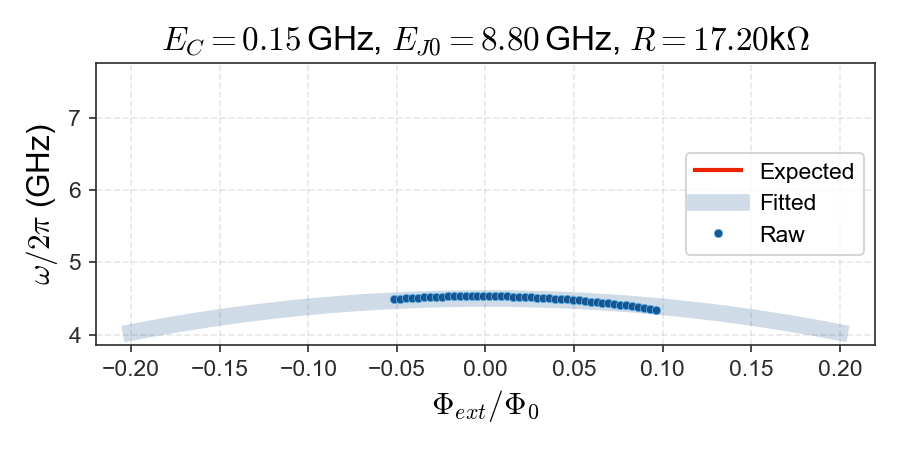

In [39]:
FILE_NAME = "C:/ExperimentBlue/2021-05_photon-source/03_mfield-sweep.vi.txt"

# Fabrication Parameters
RESISTANCE_RT = 5.67*kOhm
JJ_side = 100
#AREA_LOOP = 4.2*um * 5.8*um
L = 40*um
W = 10*um
N = 25

# Fitting Parameters
OFFSET = 0.026
MULTIPLIER = 3.36
EC = ec_interdigitated(L, W, N)
EJ0 = 8.8
FLUX_LIST = np.linspace(-0.2, 0.2, 101)

# loaded
with open(FILE_NAME) as fin:
    lines = (line for line in fin if not line.startswith('#'))
    experiment_data = np.loadtxt(lines)
experiment_x = (experiment_data[:, 0] - OFFSET) * MULTIPLIER
experiment_y = experiment_data[:, 1]

# Expected
expected = scq.TunableTransmon(
    EJmax=2*eval_expected_ej0(RESISTANCE_RT),
    EC=ec_interdigitated(L, W, N),
    d=0,       # no assymerty
    flux=0.0,  # defaults
    ng=0.0,
    ncut=21
)
expected_01 = expected.get_spectrum_vs_paramvals(param_name='flux',
                                                  param_vals=FLUX_LIST,
                                                  evals_count=2,
                                                  subtract_ground=True
                                                  ).energy_table[:, 1]
# Fitting
fitted = scq.TunableTransmon(
    EJmax=2*EJ0,
    EC=EC,
    d=0,       # no assymerty
    flux=0.0,  # defaults
    ng=0.0,
    ncut=21
)
fitted_01 = fitted.get_spectrum_vs_paramvals(param_name='flux',
                                                  param_vals=FLUX_LIST,
                                                  evals_count=2,
                                                  subtract_ground=True
                                                  ).energy_table[:, 1]

# Plot
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
expected_plot, = ax.plot(FLUX_LIST, expected_01,
        linestyle="-",
        color=MY_COLOURS["DarkRed"],
        label="Expected",
        linewidth=2, 
        )
fitted_plot, = ax.plot(FLUX_LIST, fitted_01,
        linestyle="-",
        color=MY_COLOURS["DarkBlue"],
        label="Fitted",
        linewidth=8,
        alpha=0.2
        )

experiment_plot, = ax.plot(experiment_x, experiment_y,
        marker="o",
        color=MY_COLOURS["DarkBlue"],
        markeredgecolor="C2",
        label="Raw",
        markeredgewidth="0.4", markersize=4, alpha=0.95,
        linestyle="")

ax.set_xlabel("$\Phi_{ext}/\Phi_0$", fontsize=15)
ax.set_ylabel("$\omega/2\pi$ (GHz)", fontsize=15)
ax.set_title(f"$E_C={EC:.2f}\,$GHz, $E_{{J0}}={EJ0:.2f}\,$GHz, $R={eval_resitance_from_ej0(JJ_side, JJ_side, EJ0):.2f}$k$\Omega$", fontsize=16)
ax.legend()
plt.tight_layout()

In [40]:
CONTINUOUS_UPDATE = False
def update(EC, EJ0, offset, multiplier, toggle_experiment: bool):
    expected_plot.set_visible(toggle_experiment)

    experiment_plot.set_xdata((experiment_data[:, 0] - offset) * multiplier)
    
    ax.set_title(f"$E_C={EC:.2f}\,$GHz, $E_{{J0}}={EJ0:.2f}\,$GHz, $R={eval_resitance_from_ej0(JJ_side, JJ_side, EJ0):.2f}$k$\Omega$", fontsize=16)
    scq_energies = scq.TunableTransmon(
        EJmax=2*EJ0,
        EC=EC,
        d=0,       # no assymerty
        flux=0.0,  # defaults
        ng=0.0,
        ncut=21
        ).get_spectrum_vs_paramvals(param_name='flux',
                                                      param_vals=FLUX_LIST,
                                                      evals_count=2,
                                                      subtract_ground=True
                                                      ).energy_table
    fitted_plot.set_ydata(scq_energies[:, 1])
    
    ax.relim()
    ax.autoscale_view()
    
EC_widget = ipywidgets.FloatSlider(
    min=0.01, max=2, step=0.01,
    description="$E_{C}$ (GHz)", value=EC,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
EC_widget.style.handle_color = 'red'
EJ0_widget = ipywidgets.FloatSlider(
    min=1, max=40,
    description="$E_{J0}$ (GHz)", value=EJ0,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
EJ0_widget.style.handle_color = 'red'

offset_widget = ipywidgets.FloatSlider(
    min=-0.1, max=0.1, step=0.001,
    readout_format='.4f',
    description="offset", value=OFFSET,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
multiplier_widget = ipywidgets.FloatSlider(
    min=0.1, max=10, step=0.001,
    description="multiplier", value=MULTIPLIER,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
toggle_widget = ipywidgets.Checkbox(
    description='Toggle Expected',
    value=False,
    continuous_update=CONTINUOUS_UPDATE
)

ui = ipywidgets.GridspecLayout(5, 1)
ui[0, :] = EC_widget
ui[1, :] = EJ0_widget
ui[2, :] = offset_widget
ui[3, :] = multiplier_widget
ui[4, :] = toggle_widget

out = ipywidgets.interactive_output(
    update,
    {
        # Key is the subsituted parameter, Values is the widget to use
        "EC": EC_widget,
        "EJ0": EJ0_widget,
        "offset": offset_widget,
        "multiplier": multiplier_widget,
        "toggle_experiment": toggle_widget
    }
)

display(ui, out)

GridspecLayout(children=(FloatSlider(value=0.15421686746987956, continuous_update=False, description='$E_{C}$ …

Output()

# Rabi

In [41]:
def rabi_model(t, tDec, T, A, B, C, D, *args):
    """
    __ Description __
    Fits Rabi oscillations of the format
    A e^(-t/tDec) cos(2π t / T + B) + C
    """

    return A * np.sin(2 * np.pi * t / T + B) * np.exp(-t / tDec) + C*t + D

def rabi_model_beating(t, t_dec, T, A, B, C, D, E, t_beat):
    """
    OLD! Need to move t_beat to the end!
    __ Description __
    Fits Rabi oscillations of the format
    A e^(-t/tDec) cos(2π t / T + B)sin(2π t / t_beat + E) + Ct + D
    """

    return A * np.sin(2 * np.pi * t / T + B) * np.sin(2 * np.pi * t / t_beat + E) *  np.exp(-t / t_dec) + C*t + D

## 12_rabi-power-sweep

In [113]:
RABI_MODEL = rabi_model
# FILENAME = "/Users/CCCP/creamy_seas/monday_starts_on_saturday/lab-results/2021-05-05_single-jj-xmon/Qubit26_2021-05_single-jj-xmon_04_rabi-sweep-q2_VNA(-25)_GEN(10)_amplitude.txt"
FILENAME = "C:/ExperimentBlue/2021-05_photon-source/12_rabi-power-sweep.vi.txt"

with open(FILENAME) as fin:
    DATA = np.loadtxt(FILENAME)
    
    first_line = fin.readline().split()
    f_range = [float(first_line[1]), float(first_line[2]), DATA.shape[0]]
    
    second_line = fin.readline().split()
    y_range = [float(second_line[1]), float(second_line[2]), DATA.shape[1]]    

T_DATA = np.linspace(*y_range)
F_DATA = np.linspace(*f_range)
try:
    # Load in default fit values for this file
    with open(f"data/cache/{os.path.basename(FILENAME)}.cache") as fin:
        fit_data = {int(k): v for k, v in json.load(fin).items()}
    print("Loaded cached parameters!")
except:
    fit_data = {}

Loaded cached parameters!


 c:\users\astafiev experiment\appdata\local\programs\python\python38\lib\site-packages\scipy\optimize\minpack.py: 828

<IPython.core.display.Javascript object>


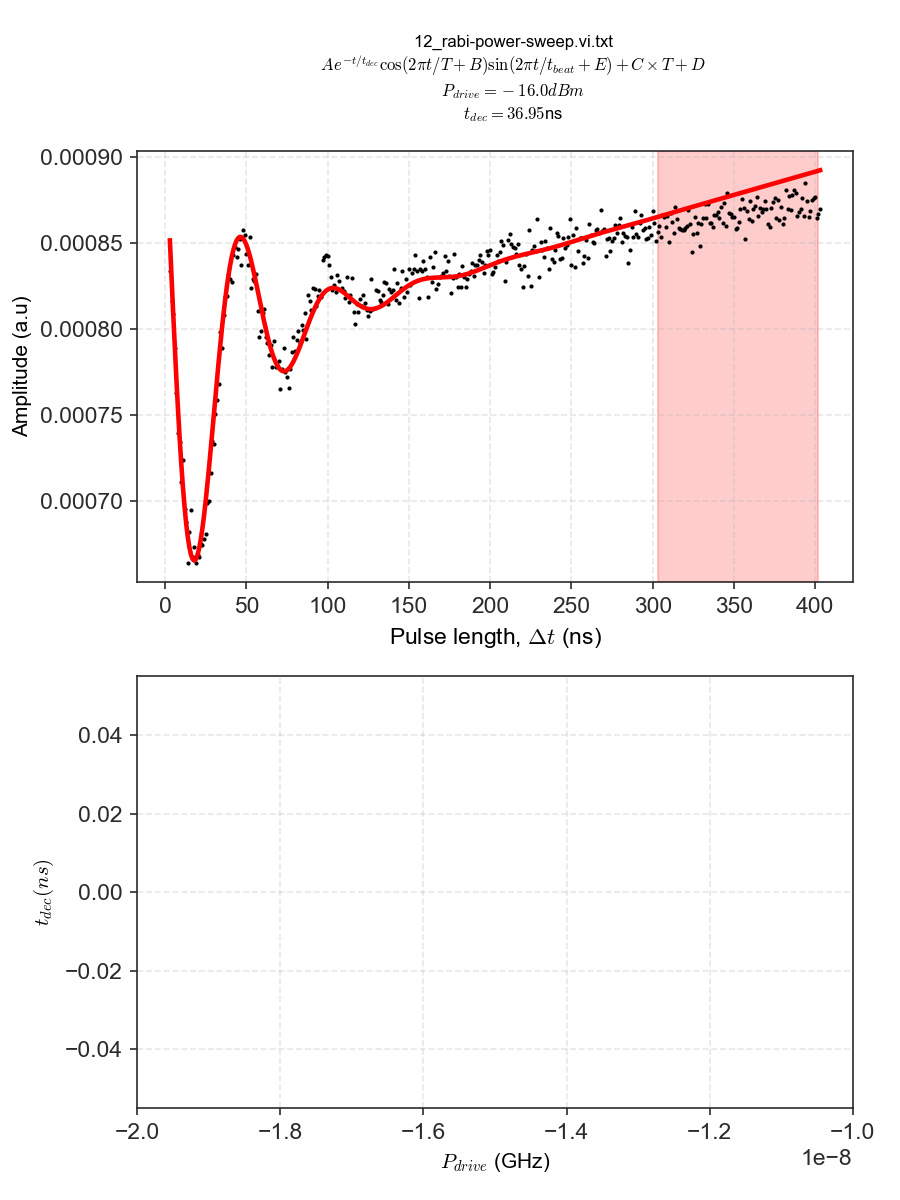

In [105]:
# Initial Guess
cut = (300, 399)
INDEX = 2
t_dec = 5328.30
T = 123.5
t_beat = 8000
A = 0.001
B = 4.44
C = 0
D = 0.0008
E = np.pi / 2

# Fitting
y_data = DATA[INDEX]
try:
    (popt, _) = curve_fit(
        RABI_MODEL,
        np.delete(T_DATA, np.arange(cut[0], cut[1])),
        np.delete(y_data, np.arange(cut[0], cut[1])),
        [t_dec, T, A, B, C, D, E, t_beat]
    )
except RuntimeError:
    popt = (t_dec, T, A, B, C, D, E, t_beat)

# Plotting
fix, ax = plt.subplots(2, 1, figsize=(6, 8))
raw, = ax[0].plot(T_DATA, y_data, color="black", marker=".", linestyle='')
fitting, = ax[0].plot(T_DATA, RABI_MODEL(T_DATA, *popt), color="blue")
user_fitting, = ax[0].plot(T_DATA, RABI_MODEL(T_DATA, t_dec, T, A, B, C, D, E, t_beat), color="red", linewidth=2.2)
ax[0].axvspan(T_DATA[cut[0]], T_DATA[cut[1]], color='red', alpha=0.2)
ax[0].set_xlabel("Pulse length, $\Delta t$ (ns)", fontsize=11)
ax[0].set_ylabel("Amplitude (a.u)", fontsize=10)
ax[0].set_title(f"""
    {FILENAME.split("/")[-1]}
     $Ae^{{-t/t_{{dec}}}} \cos(2\pi{{t}}/T + B) \sin(2\pi{{t}}/t_{{beat}} + E) + C\\times{{T}} + D$
    $P_{{drive}} = {F_DATA[INDEX]}dBm$ 
    $t_{{dec}} = {popt[0]:.2f}$ns
    """, fontsize=8)

ax[1].set_xlabel("$P_{drive}$ (GHz)", fontsize=10)
ax[1].set_ylabel("$t_{dec} (ns)$", fontsize=10)
ax[1].set_xlim(f_range[0]/GHz, f_range[1]/GHz)
param_plot, = ax[1].plot([], [], marker="o", linestyle='')
plt.tight_layout()

# Interactivity
def update(t_dec, T, t_beat, A, B, C, D, E, 
           cut, INDEX, user_toggle, fit_toggle):
    C = C / 10**6
    y_data = DATA[INDEX]
    try:
        (popt, _) = curve_fit(
            RABI_MODEL,
            np.delete(T_DATA, np.arange(cut[0], cut[1])),
            np.delete(y_data, np.arange(cut[0], cut[1])),
            [t_dec, T, A, B, C, D, E, t_beat]
        )
    except RuntimeError:
        print("Failed regression!")
        popt = (t_dec, T, A, B, C, D, E, t_beat)
    ax[0].set_title(f"""
        {FILENAME.split("/")[-1]}
        $Ae^{{-t/t_{{dec}}}} \cos(2\pi{{t}}/T + B) \sin(2\pi{{t}}/t_{{beat}} + E) + C\\times{{T}} + D$
        $P_{{drive}} = {F_DATA[INDEX]}dBm$ 
        $t_{{dec}} = {popt[0]:.2f}$ns
        """, fontsize=8)
    fitting.set_ydata(RABI_MODEL(T_DATA, *popt))
    raw.set_ydata(y_data)
    user_fitting.set_ydata(RABI_MODEL(T_DATA, t_dec, T, A, B, C, D, E, t_beat))
    ax[0].patches = []
    ax[0].axvspan(T_DATA[cut[0]], T_DATA[cut[1]], color='red', alpha=0.2)

    user_fitting.set_visible(user_toggle)
    fitting.set_visible(fit_toggle)
    ax[0].relim()
    ax[0].autoscale_view()
    return popt

def store_fit(_):
    INDEX = INDEX_widget.value

    fit_data[INDEX] = list(update(
        t_dec_widget.value, T_widget.value, t_beat_widget.value, A_widget.value, B_widget.value, C_widget.value, 
        D_widget.value, E_widget.value, CUT_widget.value, 
        INDEX,  user_toggle_widget.value,  fit_toggle_widget.value))

    unpacked_fit_data = np.array([[F_DATA[k], v[0]]
                                  for k, v in fit_data.items()])
    unpacked_f = unpacked_fit_data[:, 0]/GHz
    unpacked_t_dec = unpacked_fit_data[:, 1]

    param_plot.set_data(unpacked_f, unpacked_t_dec)
    ax[1].relim()
    ax[1].autoscale_view()
    print(f"Stored parameters!{fit_data}")
def store_user_fit(_):
    INDEX = INDEX_widget.value

    fit_data[INDEX] = (t_dec_widget.value, T_widget.value, t_beat_widget.value, A_widget.value, B_widget.value, C_widget.value/10**6, 
        D_widget.value, E_widget.value)

    unpacked_fit_data = np.array([[F_DATA[k], v[0]]
                                  for k, v in fit_data.items()])
    unpacked_f = unpacked_fit_data[:, 0]/GHz
    unpacked_t_dec = unpacked_fit_data[:, 1]

    param_plot.set_data(unpacked_f, unpacked_t_dec)
    ax[1].relim()
    ax[1].autoscale_view()
    print(f"Stored parameters!{fit_data}")
def dump_parameters(_):
    """Parameters saved to file so that they can be read later on"""
    INDEX = INDEX_widget.value
    save_file = f"data/cache/{os.path.basename(FILENAME)}.cache"
    with open(save_file, "w") as fout:
        json.dump(fit_data, fout)
    print(f"Parameters saved to file: '{save_file}'")
def load_parameters(_):
    """Set settings to the parameters in dictionary"""
    INDEX = INDEX_widget.value
    if INDEX in fit_data:
        print(f"Loaded parameters!: {fit_data[INDEX]}")
        t_dec_widget.value = fit_data[INDEX][0]
        T_widget.value = fit_data[INDEX][1]
        A_widget.value = fit_data[INDEX][2]
        B_widget.value = fit_data[INDEX][3]
        C_widget.value = fit_data[INDEX][4] * 10**6
        D_widget.value = fit_data[INDEX][5]
        E_widget.value = fit_data[INDEX][6]
        t_beat_widget.value = fit_data[INDEX][7]
    else:
        print("No parameters saved for this plot")

In [106]:
CONTINUOUS_UPDATE = False
t_dec_widget = ipywidgets.FloatText(
#     min=1, max=100,
    description="$t_{dec}$ (ns)", value=t_dec,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
t_dec_widget.style.handle_color = 'red'
t_beat_widget = ipywidgets.FloatText(
#     min=1, max=10000,
    description="$t_{beat}$ (ns)", value=t_beat,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
t_beat_widget.style.handle_color = 'red'

T_widget = ipywidgets.FloatText(
#     min=10, max=200, step=0.25,
    description="$T$ (nd)", value=T,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
T_widget.style.handle_color = 'red'

CUT_widget = ipywidgets.SelectionRangeSlider(
    options=[(i, i) for i, t in enumerate(T_DATA)],
    description='Cut points', value=cut,
    layout=ipywidgets.Layout(width='90%')
)
CUT_widget.style.handle_color = 'blue'
A_widget = ipywidgets.FloatText(
#     min=0, max=0.01, step=0.0001,
    readout_format='.5f',
    description="A", value=A,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
B_widget = ipywidgets.FloatText(
#     min=0, max=2*np.pi, step=0.01,
    description="B", value=B,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
C_widget = ipywidgets.FloatText(
#     min=-20, max=20, step=0.1,
    description="C * 10^6", value=C * 10**6,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
D_widget = ipywidgets.FloatText(
#     min=-0.5, max=0.5, 
    step=0.0001,
    description="D", value=D,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
E_widget = ipywidgets.FloatText(
#     min=0, max=2*np.pi, step=0.01,
    description="E", value=E,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
INDEX_widget = ipywidgets.IntSlider(
    min=0, max=len(F_DATA) - 1,
    description="idx", value=INDEX,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
INDEX_widget.style.handle_color = 'blue'

store_fit_widget = ipywidgets.Button(
    description='Store Regression Parameters',
    icon='arrow-down'  # (FontAwesome names without the `fa-` prefix),
)
store_fit_widget.on_click(store_fit)
store_user_fit_widget = ipywidgets.Button(
    description='Store User Parameters',
    icon='arrow-down'  # (FontAwesome names without the `fa-` prefix),
)
store_user_fit_widget.on_click(store_user_fit)
load_parameters_widget = ipywidgets.Button(
    description='Load Fit Parameters',
    icon='arrow-up',     layout=ipywidgets.Layout(width='90%'),
)
load_parameters_widget.on_click(load_parameters)
dump_widget = ipywidgets.Button(
    description='Save Parameters to file',
    icon='save', layout=ipywidgets.Layout(width='90%')
)
dump_widget.on_click(dump_parameters)
user_toggle_widget = ipywidgets.Checkbox(
    description='User Fitting',
    value=True,
    continuous_update=CONTINUOUS_UPDATE
)
fit_toggle_widget = ipywidgets.Checkbox(
    description='Regression Fitting',
    value=False,
    continuous_update=CONTINUOUS_UPDATE
)

ui = ipywidgets.GridspecLayout(12, 4)
ui[0, :] = t_dec_widget
ui[1, :] = T_widget
ui[2, :] = t_beat_widget
ui[3, :] = A_widget
ui[4, :] = B_widget
ui[5, :] = C_widget
ui[6, :] = D_widget
ui[7, :] = E_widget
ui[8, :] = CUT_widget
ui[9, :] = INDEX_widget
ui[10, 0] = user_toggle_widget
ui[10, 1] = store_user_fit_widget
ui[10, 2] = fit_toggle_widget
ui[10, 3]= store_fit_widget
ui[11, :1] = dump_widget
ui[11, 2:] = load_parameters_widget

out = ipywidgets.interactive_output(
    update,
    {
        # Key is the subsituted parameter, Values is the widget to use
        "t_dec": t_dec_widget,
        "T": T_widget,
        "t_beat": t_beat_widget,
        "A": A_widget,
        "B": B_widget,
        "C": C_widget,
        "D": D_widget,
        "E": E_widget,
        "INDEX": INDEX_widget,
        "cut": CUT_widget,
        "user_toggle": user_toggle_widget,
        "fit_toggle": fit_toggle_widget
    }
)

display(ui, out)

GridspecLayout(children=(FloatText(value=5328.3, description='$t_{dec}$ (ns)', layout=Layout(grid_area='widget…

Output()

Loaded parameters!: [37.3746796769031, 55.790914253862326, 0.0002045001841296409, 2.4369072812801575, 2.711736895042397e-07, 0.0007827704615501297, 1.5707963267948966, 8000.0]


<IPython.core.display.Javascript object>


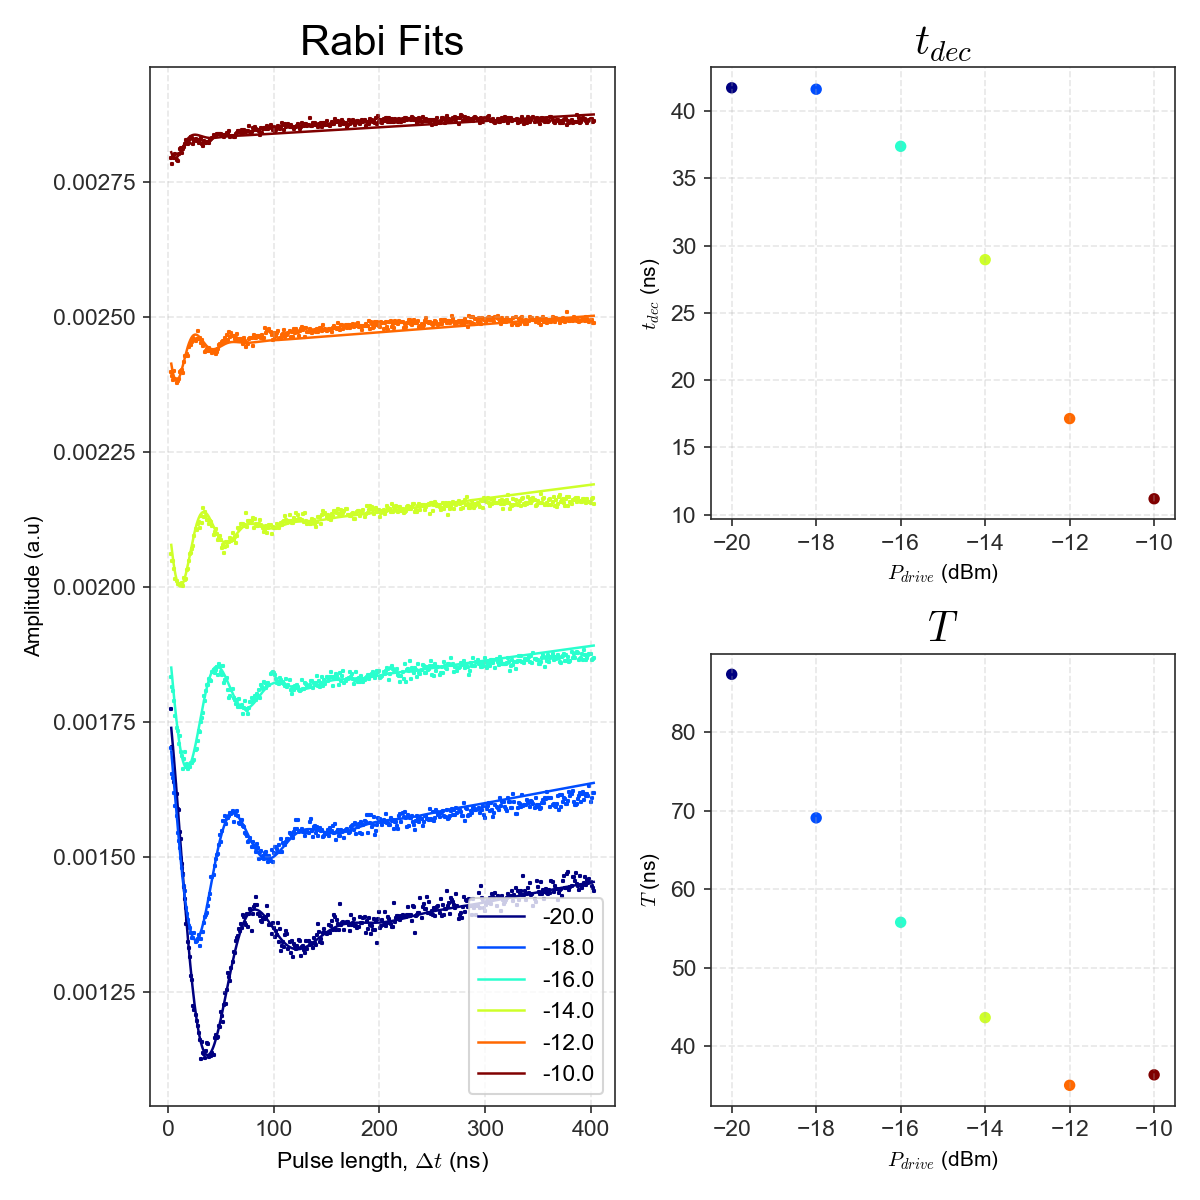

In [120]:
# Summarise the fittings:
SPACING = 0.0005
cmap = plt.cm.jet(np.linspace(0, 1, len(fit_data)))
fit_data = dict(sorted(fit_data.items()))

# Plot T, t_dec for different frequencies and the rabi plots
# fix, ax = plt.subplots(3, 1, figsize=(4,9))
plt.figure(figsize=(8, 8))
gs = gridspec.GridSpec(2, 2)

ax0 = plt.subplot(gs[:, 0])
ax0.set_title("Rabi Fits")
ax0.set_xlabel("Pulse length, $\Delta t$ (ns)", fontsize=11)
ax0.set_ylabel("Amplitude (a.u)", fontsize=10)

ax1 = plt.subplot(gs[0, 1])
ax1.set_title("$t_{dec}$")
ax1.set_xlabel("$P_{drive}$ (dBm)", fontsize=10)
ax1.set_ylabel("$t_{dec}$ (ns)", fontsize=10)

ax2 = plt.subplot(gs[1, 1])
ax2.set_title("$T$")
ax2.set_xlabel("$P_{drive}$ (dBm)", fontsize=10)
ax2.set_ylabel("$T$ (ns)", fontsize=10)

# Plot Rabi
for i, (idx, val) in enumerate(fit_data.items()):
    ax0.plot(T_DATA, i * SPACING + rabi_model_beating(T_DATA, *val), color=cmap[i], label=F_DATA[idx])
    ax0.scatter(T_DATA, i * SPACING + DATA[idx], marker=',', color=cmap[i], s=1)
    
# Plot t_dec and T
unpacked_fit_data = np.array([[F_DATA[k], v[0], v[1]] for k, v in fit_data.items()])
unpacked_f = unpacked_fit_data[:, 0]
ax1.scatter(unpacked_f, unpacked_fit_data[:, 1], marker='o', s=20, color=cmap) 
ax2.scatter(unpacked_f, unpacked_fit_data[:, 2], marker='o', s=20, color=cmap) 

ax0.legend()
plt.tight_layout()
#plt.savefig(FILENAME.replace("txt", "pdf"))

## 13_rabi-bucket-width-sweep

In [137]:
RABI_MODEL = rabi_model
# FILENAME = "/Users/CCCP/creamy_seas/monday_starts_on_saturday/lab-results/2021-05-05_single-jj-xmon/Qubit26_2021-05_single-jj-xmon_04_rabi-sweep-q2_VNA(-25)_GEN(10)_amplitude.txt"
FILENAME = "C:/ExperimentBlue/2021-05_photon-source/13_rabi-bucket-width-sweep.vi.txt"
VARIABLE = "Bucket width (ns)"

with open(FILENAME) as fin:
    DATA = np.loadtxt(FILENAME)
    
    first_line = fin.readline().split()
    f_range = [float(first_line[1]), float(first_line[2]), DATA.shape[0]]
    
    second_line = fin.readline().split()
    y_range = [float(second_line[1]), float(second_line[2]), DATA.shape[1]]    

T_DATA = np.linspace(*y_range)
F_DATA = np.linspace(*f_range)
try:
    # Load in default fit values for this file
    with open(f"data/cache/{os.path.basename(FILENAME)}.cache") as fin:
        fit_data = {int(k): v for k, v in json.load(fin).items()}
    print("Loaded cached parameters!")
except:
    fit_data = {}

Loaded cached parameters!


In [138]:
# Initial Guess
cut = (200, 300)
INDEX = 0
t_dec = 5328.30
T = 123.5
t_beat = 8000
A = 0.001
B = 4.44
C = 0
D = 0.0008
E = np.pi / 2

# Fitting
y_data = DATA[INDEX]
try:
    (popt, _) = curve_fit(
        RABI_MODEL,
        np.delete(T_DATA, np.arange(cut[0], cut[1])),
        np.delete(y_data, np.arange(cut[0], cut[1])),
        [t_dec, T, A, B, C, D, E, t_beat]
    )
except RuntimeError:
    popt = (t_dec, T, A, B, C, D, E, t_beat)

# Plotting
fix, ax = plt.subplots(2, 1, figsize=(6, 8))
raw, = ax[0].plot(T_DATA, y_data, color="black", marker=".", linestyle='')
fitting, = ax[0].plot(T_DATA, RABI_MODEL(T_DATA, *popt), color="blue")
user_fitting, = ax[0].plot(T_DATA, RABI_MODEL(T_DATA, t_dec, T, A, B, C, D, E, t_beat), color="red", linewidth=2.2)
ax[0].axvspan(T_DATA[cut[0]], T_DATA[cut[1]], color='red', alpha=0.2)
ax[0].set_xlabel("Pulse length, $\Delta t$ (ns)", fontsize=11)
ax[0].set_ylabel("Amplitude (a.u)", fontsize=10)
ax[0].set_title(f"""
    {FILENAME.split("/")[-1]}
     $Ae^{{-t/t_{{dec}}}} \cos(2\pi{{t}}/T + B) \sin(2\pi{{t}}/t_{{beat}} + E) + C\\times{{T}} + D$
    {VARIABLE} = {F_DATA[INDEX]}
    $t_{{dec}} = {popt[0]:.2f}$ns
    """, fontsize=8)

ax[1].set_xlabel("$P_{drive}$ (GHz)", fontsize=10)
ax[1].set_ylabel("$t_{dec} (ns)$", fontsize=10)
ax[1].set_xlim(f_range[0]/GHz, f_range[1]/GHz)
param_plot, = ax[1].plot([], [], marker="o", linestyle='')
plt.tight_layout()

# Interactivity
def update(t_dec, T, t_beat, A, B, C, D, E, 
           cut, INDEX, user_toggle, fit_toggle):
    C = C / 10**6
    y_data = DATA[INDEX]
    try:
        (popt, _) = curve_fit(
            RABI_MODEL,
            np.delete(T_DATA, np.arange(cut[0], cut[1])),
            np.delete(y_data, np.arange(cut[0], cut[1])),
            [t_dec, T, A, B, C, D, E, t_beat]
        )
    except RuntimeError:
        print("Failed regression!")
        popt = (t_dec, T, A, B, C, D, E, t_beat)
    ax[0].set_title(f"""
        {FILENAME.split("/")[-1]}
        $Ae^{{-t/t_{{dec}}}} \cos(2\pi{{t}}/T + B) \sin(2\pi{{t}}/t_{{beat}} + E) + C\\times{{T}} + D$
        {VARIABLE} = {F_DATA[INDEX]}
        $t_{{dec}} = {popt[0]:.2f}$ns
        """, fontsize=8)
    fitting.set_ydata(RABI_MODEL(T_DATA, *popt))
    raw.set_ydata(y_data)
    user_fitting.set_ydata(RABI_MODEL(T_DATA, t_dec, T, A, B, C, D, E, t_beat))
    ax[0].patches = []
    ax[0].axvspan(T_DATA[cut[0]], T_DATA[cut[1]], color='red', alpha=0.2)

    user_fitting.set_visible(user_toggle)
    fitting.set_visible(fit_toggle)
    ax[0].relim()
    ax[0].autoscale_view()
    return popt

def store_fit(_):
    INDEX = INDEX_widget.value

    fit_data[INDEX] = list(update(
        t_dec_widget.value, T_widget.value, t_beat_widget.value, A_widget.value, B_widget.value, C_widget.value, 
        D_widget.value, E_widget.value, CUT_widget.value, 
        INDEX,  user_toggle_widget.value,  fit_toggle_widget.value))

    unpacked_fit_data = np.array([[F_DATA[k], v[0]]
                                  for k, v in fit_data.items()])
    unpacked_f = unpacked_fit_data[:, 0]/GHz
    unpacked_t_dec = unpacked_fit_data[:, 1]

    param_plot.set_data(unpacked_f, unpacked_t_dec)
    ax[1].relim()
    ax[1].autoscale_view()
    print(f"Stored parameters!{fit_data}")
def store_user_fit(_):
    INDEX = INDEX_widget.value

    fit_data[INDEX] = (t_dec_widget.value, T_widget.value, t_beat_widget.value, A_widget.value, B_widget.value, C_widget.value/10**6, 
        D_widget.value, E_widget.value)

    unpacked_fit_data = np.array([[F_DATA[k], v[0]]
                                  for k, v in fit_data.items()])
    unpacked_f = unpacked_fit_data[:, 0]/GHz
    unpacked_t_dec = unpacked_fit_data[:, 1]

    param_plot.set_data(unpacked_f, unpacked_t_dec)
    ax[1].relim()
    ax[1].autoscale_view()
    print(f"Stored parameters!{fit_data}")
def dump_parameters(_):
    """Parameters saved to file so that they can be read later on"""
    INDEX = INDEX_widget.value
    save_file = f"data/cache/{os.path.basename(FILENAME)}.cache"
    with open(save_file, "w") as fout:
        json.dump(fit_data, fout)
    print(f"Parameters saved to file: '{save_file}'")
def load_parameters(_):
    """Set settings to the parameters in dictionary"""
    INDEX = INDEX_widget.value
    if INDEX in fit_data:
        print(f"Loaded parameters!: {fit_data[INDEX]}")
        t_dec_widget.value = fit_data[INDEX][0]
        T_widget.value = fit_data[INDEX][1]
        A_widget.value = fit_data[INDEX][2]
        B_widget.value = fit_data[INDEX][3]
        C_widget.value = fit_data[INDEX][4] * 10**6
        D_widget.value = fit_data[INDEX][5]
        E_widget.value = fit_data[INDEX][6]
        t_beat_widget.value = fit_data[INDEX][7]
    else:
        print("No parameters saved for this plot")

 c:\users\astafiev experiment\appdata\local\programs\python\python38\lib\site-packages\scipy\optimize\minpack.py: 828

<IPython.core.display.Javascript object>

In [139]:
CONTINUOUS_UPDATE = False
t_dec_widget = ipywidgets.FloatText(
#     min=1, max=100,
    description="$t_{dec}$ (ns)", value=t_dec,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
t_dec_widget.style.handle_color = 'red'
t_beat_widget = ipywidgets.FloatText(
#     min=1, max=10000,
    description="$t_{beat}$ (ns)", value=t_beat,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
t_beat_widget.style.handle_color = 'red'

T_widget = ipywidgets.FloatText(
#     min=10, max=200, step=0.25,
    description="$T$ (nd)", value=T,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
T_widget.style.handle_color = 'red'

CUT_widget = ipywidgets.SelectionRangeSlider(
    options=[(i, i) for i, t in enumerate(T_DATA)],
    description='Cut points', value=cut,
    layout=ipywidgets.Layout(width='90%')
)
CUT_widget.style.handle_color = 'blue'
A_widget = ipywidgets.FloatText(
#     min=0, max=0.01, step=0.0001,
    readout_format='.5f',
    description="A", value=A,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
B_widget = ipywidgets.FloatText(
#     min=0, max=2*np.pi, step=0.01,
    description="B", value=B,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
C_widget = ipywidgets.FloatText(
#     min=-20, max=20, step=0.1,
    description="C * 10^6", value=C * 10**6,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
D_widget = ipywidgets.FloatText(
#     min=-0.5, max=0.5, 
    step=0.0001,
    description="D", value=D,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
E_widget = ipywidgets.FloatSlider(
    min=0, max=2*np.pi, step=0.01,
    description="E", value=E,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
INDEX_widget = ipywidgets.IntSlider(
    min=0, max=len(F_DATA) - 1,
    description="idx", value=INDEX,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
INDEX_widget.style.handle_color = 'blue'

store_fit_widget = ipywidgets.Button(
    description='Store Regression Parameters',
    icon='arrow-down'  # (FontAwesome names without the `fa-` prefix),
)
store_fit_widget.on_click(store_fit)
store_user_fit_widget = ipywidgets.Button(
    description='Store User Parameters',
    icon='arrow-down'  # (FontAwesome names without the `fa-` prefix),
)
store_user_fit_widget.on_click(store_user_fit)
load_parameters_widget = ipywidgets.Button(
    description='Load Fit Parameters',
    icon='arrow-up',     layout=ipywidgets.Layout(width='90%'),
)
load_parameters_widget.on_click(load_parameters)
dump_widget = ipywidgets.Button(
    description='Save Parameters to file',
    icon='save', layout=ipywidgets.Layout(width='90%')
)
dump_widget.on_click(dump_parameters)
user_toggle_widget = ipywidgets.Checkbox(
    description='User Fitting',
    value=True,
    continuous_update=CONTINUOUS_UPDATE
)
fit_toggle_widget = ipywidgets.Checkbox(
    description='Regression Fitting',
    value=False,
    continuous_update=CONTINUOUS_UPDATE
)

ui = ipywidgets.GridspecLayout(12, 4)
ui[0, :] = t_dec_widget
ui[1, :] = T_widget
ui[2, :] = t_beat_widget
ui[3, :] = A_widget
ui[4, :] = B_widget
ui[5, :] = C_widget
ui[6, :] = D_widget
ui[7, :] = E_widget
ui[8, :] = CUT_widget
ui[9, :] = INDEX_widget
ui[10, 0] = user_toggle_widget
ui[10, 1] = store_user_fit_widget
ui[10, 2] = fit_toggle_widget
ui[10, 3]= store_fit_widget
ui[11, :1] = dump_widget
ui[11, 2:] = load_parameters_widget

out = ipywidgets.interactive_output(
    update,
    {
        # Key is the subsituted parameter, Values is the widget to use
        "t_dec": t_dec_widget,
        "T": T_widget,
        "t_beat": t_beat_widget,
        "A": A_widget,
        "B": B_widget,
        "C": C_widget,
        "D": D_widget,
        "E": E_widget,
        "INDEX": INDEX_widget,
        "cut": CUT_widget,
        "user_toggle": user_toggle_widget,
        "fit_toggle": fit_toggle_widget
    }
)

display(ui, out)

GridspecLayout(children=(FloatText(value=5328.3, description='$t_{dec}$ (ns)', layout=Layout(grid_area='widget…

Output()

Loaded parameters!: [34.6475686952524, 42.82499755672035, -0.00010660452831340759, 11.553920458529095, 2.209428428763793e-07, 0.00016966083091577396, 0.00016489814049345763, 1.5707963267948966]
Loaded parameters!: [32.858576094514184, 43.10583485682607, 0.0001237978396750232, 2.718942755559485, 3.222169325078429e-07, 0.0005840452084323294, 1.79, 1.5707963267948966]
Loaded parameters!: [34.11535158070621, 44.831683630020486, -8.345544031820321e-05, -0.11839250628314325, 4.208389212149822e-07, 0.0009323120824359325, 1.79, 1.5707963267948966]
Loaded parameters!: [31.047894695043176, 47.737425025153826, -7.836126941707222e-05, -0.189981709566156, 4.7680417713212236e-07, 0.0012650551493284955, 1.79, 1.5707963267948966]
No parameters saved for this plot
No parameters saved for this plot
Parameters saved to file: 'data/cache/13_rabi-bucket-width-sweep.vi.txt.cache'
Stored parameters!{0: [34.6475686952524, 42.82499755672035, -0.00010660452831340759, 11.553920458529095, 2.209428428763793e-07, 0

In [157]:
# Summarise the fittings:
SPACING = -0.0003
cmap = plt.cm.jet(np.linspace(0, 1, len(fit_data)))
fit_data = dict(sorted(fit_data.items()))

# Plot T, t_dec for different frequencies and the rabi plots
# fix, ax = plt.subplots(3, 1, figsize=(4,9))
plt.figure(figsize=(8, 8))
gs = gridspec.GridSpec(2, 2)

ax0 = plt.subplot(gs[:, 0])
ax0.set_title("Rabi Fits")
ax0.set_xlabel("Pulse length, $\Delta t$ (ns)", fontsize=11)
ax0.set_ylabel("Amplitude (a.u)", fontsize=10)

ax1 = plt.subplot(gs[0, 1])
ax1.set_title("$t_{dec}$")
ax1.set_xlabel(f"{VARIABLE} (dBm)", fontsize=10)
ax1.set_ylabel("$t_{dec}$ (ns)", fontsize=10)

ax2 = plt.subplot(gs[1, 1])
ax2.set_title("$T$")
ax2.set_xlabel(f"{VARIABLE}", fontsize=10)
ax2.set_ylabel("$T$ (ns)", fontsize=10)

# Plot Rabi
for i, (idx, val) in enumerate(fit_data.items()):
    ax0.plot(T_DATA, i * SPACING + rabi_model(T_DATA, *val), color=cmap[i], label=F_DATA[idx])
    ax0.scatter(T_DATA, i * SPACING + DATA[idx], marker=',', color=cmap[i], s=1)
    
# Plot t_dec and T
unpacked_fit_data = np.array([[F_DATA[k], v[0], v[1]] for k, v in fit_data.items()])
unpacked_f = unpacked_fit_data[:, 0]
ax1.scatter(unpacked_f, unpacked_fit_data[:, 1], marker='o', s=20, color=cmap) 
ax2.scatter(unpacked_f, unpacked_fit_data[:, 2], marker='o', s=20, color=cmap) 

ax0.legend()
plt.tight_layout()
plt.savefig(FILENAME.replace("txt", "svg"))

<IPython.core.display.Javascript object>

## 21_rabi-freq-sweep

In [162]:
RABI_MODEL = rabi_model
# FILENAME = "/Users/CCCP/creamy_seas/monday_starts_on_saturday/lab-results/2021-05-05_single-jj-xmon/Qubit26_2021-05_single-jj-xmon_04_rabi-sweep-q2_VNA(-25)_GEN(10)_amplitude.txt"
FILENAME = "C:/ExperimentBlue/2021-05_photon-source/21_rabi-freq-sweep.vi.txt"
VARIABLE = "Drive frequency (GHz)"

with open(FILENAME) as fin:
    DATA = np.loadtxt(FILENAME)
    
    first_line = fin.readline().split()
    f_range = [float(first_line[1]), float(first_line[2]), DATA.shape[0]]
    
    second_line = fin.readline().split()
    y_range = [float(second_line[1]), float(second_line[2]), DATA.shape[1]]    

T_DATA = np.linspace(*y_range)
F_DATA = np.linspace(*f_range)
try:
    # Load in default fit values for this file
    with open(f"data/cache/{os.path.basename(FILENAME)}.cache") as fin:
        fit_data = {int(k): v for k, v in json.load(fin).items()}
    print("Loaded cached parameters!")
except:
    fit_data = {}

In [163]:
# Initial Guess
cut = (0, 1)
INDEX = 0
t_dec = 29
T = 47
t_beat = 8000
A = 0.001
B = 4.44
C = 0
D = 0.0008
E = np.pi / 2

# Fitting
y_data = DATA[INDEX]
try:
    (popt, _) = curve_fit(
        RABI_MODEL,
        np.delete(T_DATA, np.arange(cut[0], cut[1])),
        np.delete(y_data, np.arange(cut[0], cut[1])),
        [t_dec, T, A, B, C, D, E, t_beat]
    )
except RuntimeError:
    popt = (t_dec, T, A, B, C, D, E, t_beat)

# Plotting
fix, ax = plt.subplots(2, 1, figsize=(6, 8))
raw, = ax[0].plot(T_DATA, y_data, color="black", marker=".", linestyle='')
fitting, = ax[0].plot(T_DATA, RABI_MODEL(T_DATA, *popt), color="blue")
user_fitting, = ax[0].plot(T_DATA, RABI_MODEL(T_DATA, t_dec, T, A, B, C, D, E, t_beat), color="red", linewidth=2.2)
ax[0].axvspan(T_DATA[cut[0]], T_DATA[cut[1]], color='red', alpha=0.2)
ax[0].set_xlabel("Pulse length, $\Delta t$ (ns)", fontsize=11)
ax[0].set_ylabel("Amplitude (a.u)", fontsize=10)
ax[0].set_title(f"""
    {FILENAME.split("/")[-1]}
     $Ae^{{-t/t_{{dec}}}} \cos(2\pi{{t}}/T + B) \sin(2\pi{{t}}/t_{{beat}} + E) + C\\times{{T}} + D$
    {VARIABLE} = {F_DATA[INDEX]}
    $t_{{dec}} = {popt[0]:.2f}$ns
    """, fontsize=8)

ax[1].set_xlabel("$P_{drive}$ (GHz)", fontsize=10)
ax[1].set_ylabel("$t_{dec} (ns)$", fontsize=10)
ax[1].set_xlim(f_range[0]/GHz, f_range[1]/GHz)
param_plot, = ax[1].plot([], [], marker="o", linestyle='')
plt.tight_layout()

# Interactivity
def update(t_dec, T, t_beat, A, B, C, D, E, 
           cut, INDEX, user_toggle, fit_toggle):
    C = C / 10**6
    y_data = DATA[INDEX]
    try:
        (popt, _) = curve_fit(
            RABI_MODEL,
            np.delete(T_DATA, np.arange(cut[0], cut[1])),
            np.delete(y_data, np.arange(cut[0], cut[1])),
            [t_dec, T, A, B, C, D, E, t_beat]
        )
    except RuntimeError:
        print("Failed regression!")
        popt = (t_dec, T, A, B, C, D, E, t_beat)
    ax[0].set_title(f"""
        {FILENAME.split("/")[-1]}
        $Ae^{{-t/t_{{dec}}}} \cos(2\pi{{t}}/T + B) \sin(2\pi{{t}}/t_{{beat}} + E) + C\\times{{T}} + D$
        {VARIABLE} = {F_DATA[INDEX]}
        $t_{{dec}} = {popt[0]:.2f}$ns
        """, fontsize=8)
    fitting.set_ydata(RABI_MODEL(T_DATA, *popt))
    raw.set_ydata(y_data)
    user_fitting.set_ydata(RABI_MODEL(T_DATA, t_dec, T, A, B, C, D, E, t_beat))
    ax[0].patches = []
    ax[0].axvspan(T_DATA[cut[0]], T_DATA[cut[1]], color='red', alpha=0.2)

    user_fitting.set_visible(user_toggle)
    fitting.set_visible(fit_toggle)
    ax[0].relim()
    ax[0].autoscale_view()
    return popt

def store_fit(_):
    INDEX = INDEX_widget.value

    fit_data[INDEX] = list(update(
        t_dec_widget.value, T_widget.value, t_beat_widget.value, A_widget.value, B_widget.value, C_widget.value, 
        D_widget.value, E_widget.value, CUT_widget.value, 
        INDEX,  user_toggle_widget.value,  fit_toggle_widget.value))

    unpacked_fit_data = np.array([[F_DATA[k], v[0]]
                                  for k, v in fit_data.items()])
    unpacked_f = unpacked_fit_data[:, 0]/GHz
    unpacked_t_dec = unpacked_fit_data[:, 1]

    param_plot.set_data(unpacked_f, unpacked_t_dec)
    ax[1].relim()
    ax[1].autoscale_view()
    print(f"Stored parameters!{fit_data}")
def store_user_fit(_):
    INDEX = INDEX_widget.value

    fit_data[INDEX] = (t_dec_widget.value, T_widget.value, t_beat_widget.value, A_widget.value, B_widget.value, C_widget.value/10**6, 
        D_widget.value, E_widget.value)

    unpacked_fit_data = np.array([[F_DATA[k], v[0]]
                                  for k, v in fit_data.items()])
    unpacked_f = unpacked_fit_data[:, 0]/GHz
    unpacked_t_dec = unpacked_fit_data[:, 1]

    param_plot.set_data(unpacked_f, unpacked_t_dec)
    ax[1].relim()
    ax[1].autoscale_view()
    print(f"Stored parameters!{fit_data}")
def dump_parameters(_):
    """Parameters saved to file so that they can be read later on"""
    INDEX = INDEX_widget.value
    save_file = f"data/cache/{os.path.basename(FILENAME)}.cache"
    with open(save_file, "w") as fout:
        json.dump(fit_data, fout)
    print(f"Parameters saved to file: '{save_file}'")
def load_parameters(_):
    """Set settings to the parameters in dictionary"""
    INDEX = INDEX_widget.value
    if INDEX in fit_data:
        print(f"Loaded parameters!: {fit_data[INDEX]}")
        t_dec_widget.value = fit_data[INDEX][0]
        T_widget.value = fit_data[INDEX][1]
        A_widget.value = fit_data[INDEX][2]
        B_widget.value = fit_data[INDEX][3]
        C_widget.value = fit_data[INDEX][4] * 10**6
        D_widget.value = fit_data[INDEX][5]
        E_widget.value = fit_data[INDEX][6]
        t_beat_widget.value = fit_data[INDEX][7]
    else:
        print("No parameters saved for this plot")

<IPython.core.display.Javascript object>

In [164]:
CONTINUOUS_UPDATE = False
t_dec_widget = ipywidgets.FloatText(
#     min=1, max=100,
    description="$t_{dec}$ (ns)", value=t_dec,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
t_dec_widget.style.handle_color = 'red'
t_beat_widget = ipywidgets.FloatText(
#     min=1, max=10000,
    description="$t_{beat}$ (ns)", value=t_beat,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
t_beat_widget.style.handle_color = 'red'

T_widget = ipywidgets.FloatText(
#     min=10, max=200, step=0.25,
    description="$T$ (nd)", value=T,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
T_widget.style.handle_color = 'red'

CUT_widget = ipywidgets.SelectionRangeSlider(
    options=[(i, i) for i, t in enumerate(T_DATA)],
    description='Cut points', value=cut,
    layout=ipywidgets.Layout(width='90%')
)
CUT_widget.style.handle_color = 'blue'
A_widget = ipywidgets.FloatText(
#     min=0, max=0.01, step=0.0001,
    readout_format='.5f',
    description="A", value=A,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
B_widget = ipywidgets.FloatText(
#     min=0, max=2*np.pi, step=0.01,
    description="B", value=B,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
C_widget = ipywidgets.FloatText(
#     min=-20, max=20, step=0.1,
    description="C * 10^6", value=C * 10**6,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
D_widget = ipywidgets.FloatText(
#     min=-0.5, max=0.5, 
    step=0.0001,
    description="D", value=D,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
E_widget = ipywidgets.FloatSlider(
    min=0, max=2*np.pi, step=0.01,
    description="E", value=E,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
INDEX_widget = ipywidgets.IntSlider(
    min=0, max=len(F_DATA) - 1,
    description="idx", value=INDEX,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
INDEX_widget.style.handle_color = 'blue'

store_fit_widget = ipywidgets.Button(
    description='Store Regression Parameters',
    icon='arrow-down'  # (FontAwesome names without the `fa-` prefix),
)
store_fit_widget.on_click(store_fit)
store_user_fit_widget = ipywidgets.Button(
    description='Store User Parameters',
    icon='arrow-down'  # (FontAwesome names without the `fa-` prefix),
)
store_user_fit_widget.on_click(store_user_fit)
load_parameters_widget = ipywidgets.Button(
    description='Load Fit Parameters',
    icon='arrow-up',     layout=ipywidgets.Layout(width='90%'),
)
load_parameters_widget.on_click(load_parameters)
dump_widget = ipywidgets.Button(
    description='Save Parameters to file',
    icon='save', layout=ipywidgets.Layout(width='90%')
)
dump_widget.on_click(dump_parameters)
user_toggle_widget = ipywidgets.Checkbox(
    description='User Fitting',
    value=True,
    continuous_update=CONTINUOUS_UPDATE
)
fit_toggle_widget = ipywidgets.Checkbox(
    description='Regression Fitting',
    value=False,
    continuous_update=CONTINUOUS_UPDATE
)

ui = ipywidgets.GridspecLayout(12, 4)
ui[0, :] = t_dec_widget
ui[1, :] = T_widget
ui[2, :] = t_beat_widget
ui[3, :] = A_widget
ui[4, :] = B_widget
ui[5, :] = C_widget
ui[6, :] = D_widget
ui[7, :] = E_widget
ui[8, :] = CUT_widget
ui[9, :] = INDEX_widget
ui[10, 0] = user_toggle_widget
ui[10, 1] = store_user_fit_widget
ui[10, 2] = fit_toggle_widget
ui[10, 3]= store_fit_widget
ui[11, :1] = dump_widget
ui[11, 2:] = load_parameters_widget

out = ipywidgets.interactive_output(
    update,
    {
        # Key is the subsituted parameter, Values is the widget to use
        "t_dec": t_dec_widget,
        "T": T_widget,
        "t_beat": t_beat_widget,
        "A": A_widget,
        "B": B_widget,
        "C": C_widget,
        "D": D_widget,
        "E": E_widget,
        "INDEX": INDEX_widget,
        "cut": CUT_widget,
        "user_toggle": user_toggle_widget,
        "fit_toggle": fit_toggle_widget
    }
)

display(ui, out)

GridspecLayout(children=(FloatText(value=29.0, description='$t_{dec}$ (ns)', layout=Layout(grid_area='widget00…

Output()

Stored parameters!{0: [47.55088184801398, 29.6252944018223, -0.000215627678847205, 2.5675944254867993, -6.557728184047127e-07, 0.0002407986198816845, 1.5707963267948966, 8000.0]}
Parameters saved to file: 'data/cache/21_rabi-freq-sweep.vi.txt.cache'
Loaded parameters!: [47.55088184801398, 29.6252944018223, -0.000215627678847205, 2.5675944254867993, -6.557728184047127e-07, 0.0002407986198816845, 1.5707963267948966, 8000.0]
Stored parameters!{0: [47.55088184801398, 29.6252944018223, -0.000215627678847205, 2.5675944254867993, -6.557728184047127e-07, 0.0002407986198816845, 1.5707963267948966, 8000.0], 1: [45.05433480588864, 33.21655351009584, -0.0002075082154216481, 2.4619747227295785, -5.711394090533683e-07, 0.0003179940327787289, 1.5707963267948966, 8000.0]}
Loaded parameters!: [45.05433480588864, 33.21655351009584, -0.0002075082154216481, 2.4619747227295785, -5.711394090533683e-07, 0.0003179940327787289, 1.5707963267948966, 8000.0]
Stored parameters!{0: [47.55088184801398, 29.6252944018

In [165]:
# Summarise the fittings:
SPACING = -0.0003
cmap = plt.cm.jet(np.linspace(0, 1, len(fit_data)))
fit_data = dict(sorted(fit_data.items()))

# Plot T, t_dec for different frequencies and the rabi plots
# fix, ax = plt.subplots(3, 1, figsize=(4,9))
plt.figure(figsize=(8, 8))
gs = gridspec.GridSpec(2, 2)

ax0 = plt.subplot(gs[:, 0])
ax0.set_title("Rabi Fits")
ax0.set_xlabel("Pulse length, $\Delta t$ (ns)", fontsize=11)
ax0.set_ylabel("Amplitude (a.u)", fontsize=10)

ax1 = plt.subplot(gs[0, 1])
ax1.set_title("$t_{dec}$")
ax1.set_xlabel(f"{VARIABLE} (dBm)", fontsize=10)
ax1.set_ylabel("$t_{dec}$ (ns)", fontsize=10)

ax2 = plt.subplot(gs[1, 1])
ax2.set_title("$T$")
ax2.set_xlabel(f"{VARIABLE}", fontsize=10)
ax2.set_ylabel("$T$ (ns)", fontsize=10)

# Plot Rabi
for i, (idx, val) in enumerate(fit_data.items()):
    ax0.plot(T_DATA, i * SPACING + rabi_model(T_DATA, *val), color=cmap[i], label=F_DATA[idx])
    ax0.scatter(T_DATA, i * SPACING + DATA[idx], marker=',', color=cmap[i], s=1)
    
# Plot t_dec and T
unpacked_fit_data = np.array([[F_DATA[k], v[0], v[1]] for k, v in fit_data.items()])
unpacked_f = unpacked_fit_data[:, 0]
ax1.scatter(unpacked_f, unpacked_fit_data[:, 1], marker='o', s=20, color=cmap) 
ax2.scatter(unpacked_f, unpacked_fit_data[:, 2], marker='o', s=20, color=cmap) 

ax0.legend()
plt.tight_layout()
plt.savefig(FILENAME.replace("txt", "svg"))

<IPython.core.display.Javascript object>

## 22_rabi-freq-sweep

In [183]:
RABI_MODEL = rabi_model
# FILENAME = "/Users/CCCP/creamy_seas/monday_starts_on_saturday/lab-results/2021-05-05_single-jj-xmon/Qubit26_2021-05_single-jj-xmon_04_rabi-sweep-q2_VNA(-25)_GEN(10)_amplitude.txt"
FILENAME = "C:/ExperimentBlue/2021-05_photon-source/22_rabi-freq-sweep.vi.txt"
VARIABLE = "Drive frequency (GHz)"

with open(FILENAME) as fin:
    DATA = np.loadtxt(FILENAME)
    
    first_line = fin.readline().split()
    f_range = [float(first_line[1]), float(first_line[2]), DATA.shape[0]]
    
    second_line = fin.readline().split()
    y_range = [float(second_line[1]), float(second_line[2]), DATA.shape[1]]    

T_DATA = np.linspace(*y_range)
F_DATA = np.linspace(*f_range)
try:
    # Load in default fit values for this file
    with open(f"data/cache/{os.path.basename(FILENAME)}.cache") as fin:
        fit_data = {int(k): v for k, v in json.load(fin).items()}
    print("Loaded cached parameters!")
except:
    fit_data = {}

Loaded cached parameters!


 c:\users\astafiev experiment\appdata\local\programs\python\python38\lib\site-packages\scipy\optimize\minpack.py: 828

<IPython.core.display.Javascript object>


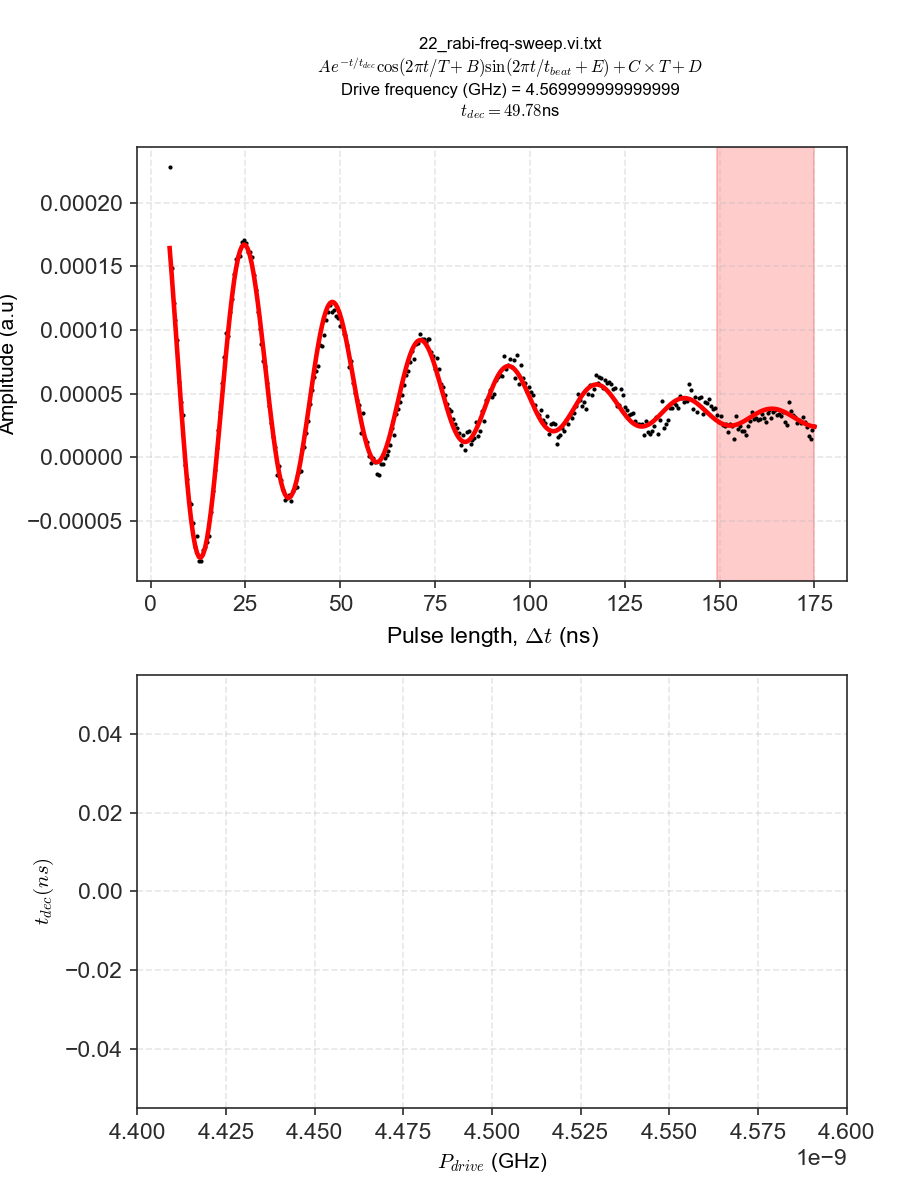

In [242]:
# Initial Guess
cut = (280, 330)
INDEX = 0
t_dec = 29
T = 47
t_beat = 8000
A = 0.001
B = 4.44
C = 0
D = 0.0008
E = np.pi / 2

# Fitting
y_data = DATA[INDEX]
try:
    (popt, _) = curve_fit(
        RABI_MODEL,
        np.delete(T_DATA, np.arange(cut[0], cut[1])),
        np.delete(y_data, np.arange(cut[0], cut[1])),
        [t_dec, T, A, B, C, D, E, t_beat]
    )
except RuntimeError:
    popt = (t_dec, T, A, B, C, D, E, t_beat)

# Plotting
fix, ax = plt.subplots(2, 1, figsize=(6, 8))
raw, = ax[0].plot(T_DATA, y_data, color="black", marker=".", linestyle='')
fitting, = ax[0].plot(T_DATA, RABI_MODEL(T_DATA, *popt), color="blue")
user_fitting, = ax[0].plot(T_DATA, RABI_MODEL(T_DATA, t_dec, T, A, B, C, D, E, t_beat), color="red", linewidth=2.2)
ax[0].axvspan(T_DATA[cut[0]], T_DATA[cut[1]], color='red', alpha=0.2)
ax[0].set_xlabel("Pulse length, $\Delta t$ (ns)", fontsize=11)
ax[0].set_ylabel("Amplitude (a.u)", fontsize=10)
ax[0].set_title(f"""
    {FILENAME.split("/")[-1]}
     $Ae^{{-t/t_{{dec}}}} \cos(2\pi{{t}}/T + B) \sin(2\pi{{t}}/t_{{beat}} + E) + C\\times{{T}} + D$
    {VARIABLE} = {F_DATA[INDEX]}
    $t_{{dec}} = {popt[0]:.2f}$ns
    """, fontsize=8)

ax[1].set_xlabel("$P_{drive}$ (GHz)", fontsize=10)
ax[1].set_ylabel("$t_{dec} (ns)$", fontsize=10)
ax[1].set_xlim(f_range[0]/GHz, f_range[1]/GHz)
param_plot, = ax[1].plot([], [], marker="o", linestyle='')
plt.tight_layout()

# Interactivity
def update(t_dec, T, t_beat, A, B, C, D, E, 
           cut, INDEX, user_toggle, fit_toggle):
    C = C / 10**6
    y_data = DATA[INDEX]
    try:
        (popt, _) = curve_fit(
            RABI_MODEL,
            np.delete(T_DATA, np.arange(cut[0], cut[1])),
            np.delete(y_data, np.arange(cut[0], cut[1])),
            [t_dec, T, A, B, C, D, E, t_beat]
        )
    except RuntimeError:
        print("Failed regression!")
        popt = (t_dec, T, A, B, C, D, E, t_beat)
    ax[0].set_title(f"""
        {FILENAME.split("/")[-1]}
        $Ae^{{-t/t_{{dec}}}} \cos(2\pi{{t}}/T + B) \sin(2\pi{{t}}/t_{{beat}} + E) + C\\times{{T}} + D$
        {VARIABLE} = {F_DATA[INDEX]}
        $t_{{dec}} = {popt[0]:.2f}$ns
        """, fontsize=8)
    fitting.set_ydata(RABI_MODEL(T_DATA, *popt))
    raw.set_ydata(y_data)
    user_fitting.set_ydata(RABI_MODEL(T_DATA, t_dec, T, A, B, C, D, E, t_beat))
    ax[0].patches = []
    ax[0].axvspan(T_DATA[cut[0]], T_DATA[cut[1]], color='red', alpha=0.2)

    user_fitting.set_visible(user_toggle)
    fitting.set_visible(fit_toggle)
    ax[0].relim()
    ax[0].autoscale_view()
    return popt

def store_fit(_):
    INDEX = INDEX_widget.value

    fit_data[INDEX] = list(update(
        t_dec_widget.value, T_widget.value, t_beat_widget.value, A_widget.value, B_widget.value, C_widget.value, 
        D_widget.value, E_widget.value, CUT_widget.value, 
        INDEX,  user_toggle_widget.value,  fit_toggle_widget.value))

    unpacked_fit_data = np.array([[F_DATA[k], v[0]]
                                  for k, v in fit_data.items()])
    unpacked_f = unpacked_fit_data[:, 0]/GHz
    unpacked_t_dec = unpacked_fit_data[:, 1]

    param_plot.set_data(unpacked_f, unpacked_t_dec)
    ax[1].relim()
    ax[1].autoscale_view()
    print(f"Stored parameters!{fit_data}")
def store_user_fit(_):
    INDEX = INDEX_widget.value

    fit_data[INDEX] = (t_dec_widget.value, T_widget.value, t_beat_widget.value, A_widget.value, B_widget.value, C_widget.value/10**6, 
        D_widget.value, E_widget.value)

    unpacked_fit_data = np.array([[F_DATA[k], v[0]]
                                  for k, v in fit_data.items()])
    unpacked_f = unpacked_fit_data[:, 0]/GHz
    unpacked_t_dec = unpacked_fit_data[:, 1]

    param_plot.set_data(unpacked_f, unpacked_t_dec)
    ax[1].relim()
    ax[1].autoscale_view()
    print(f"Stored parameters!{fit_data}")
def dump_parameters(_):
    """Parameters saved to file so that they can be read later on"""
    INDEX = INDEX_widget.value
    save_file = f"data/cache/{os.path.basename(FILENAME)}.cache"
    with open(save_file, "w") as fout:
        json.dump(fit_data, fout)
    print(f"Parameters saved to file: '{save_file}'")
def load_parameters(_):
    """Set settings to the parameters in dictionary"""
    INDEX = INDEX_widget.value
    if INDEX in fit_data:
        print(f"Loaded parameters!: {fit_data[INDEX]}")
        t_dec_widget.value = fit_data[INDEX][0]
        T_widget.value = fit_data[INDEX][1]
        A_widget.value = fit_data[INDEX][2]
        B_widget.value = fit_data[INDEX][3]
        C_widget.value = fit_data[INDEX][4] * 10**6
        D_widget.value = fit_data[INDEX][5]
        E_widget.value = fit_data[INDEX][6]
        t_beat_widget.value = fit_data[INDEX][7]
    else:
        print("No parameters saved for this plot")

In [243]:
CONTINUOUS_UPDATE = False
t_dec_widget = ipywidgets.FloatText(
#     min=1, max=100,
    description="$t_{dec}$ (ns)", value=t_dec,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
t_dec_widget.style.handle_color = 'red'
t_beat_widget = ipywidgets.FloatText(
#     min=1, max=10000,
    description="$t_{beat}$ (ns)", value=t_beat,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
t_beat_widget.style.handle_color = 'red'

T_widget = ipywidgets.FloatText(
#     min=10, max=200, step=0.25,
    description="$T$ (nd)", value=T,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
T_widget.style.handle_color = 'red'

CUT_widget = ipywidgets.SelectionRangeSlider(
    options=[(i, i) for i, t in enumerate(T_DATA)],
    description='Cut points', value=cut,
    layout=ipywidgets.Layout(width='90%')
)
CUT_widget.style.handle_color = 'blue'
A_widget = ipywidgets.FloatText(
#     min=0, max=0.01, step=0.0001,
    readout_format='.5f',
    description="A", value=A,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
B_widget = ipywidgets.FloatSlider(
    min=0, max=2*np.pi, step=0.01,
    description="B", value=B,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
C_widget = ipywidgets.FloatText(
#     min=-20, max=20, step=0.1,
    description="C * 10^6", value=C * 10**6,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
D_widget = ipywidgets.FloatText(
#     min=-0.5, max=0.5, 
    step=0.0001,
    description="D", value=D,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
E_widget = ipywidgets.FloatSlider(
    min=0, max=2*np.pi, step=0.01,
    description="E", value=E,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
INDEX_widget = ipywidgets.IntSlider(
    min=0, max=len(F_DATA) - 1,
    description="idx", value=INDEX,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
INDEX_widget.style.handle_color = 'blue'

store_fit_widget = ipywidgets.Button(
    description='Store Regression Parameters',
    icon='arrow-down'  # (FontAwesome names without the `fa-` prefix),
)
store_fit_widget.on_click(store_fit)
store_user_fit_widget = ipywidgets.Button(
    description='Store User Parameters',
    icon='arrow-down'  # (FontAwesome names without the `fa-` prefix),
)
store_user_fit_widget.on_click(store_user_fit)
load_parameters_widget = ipywidgets.Button(
    description='Load Fit Parameters',
    icon='arrow-up',     layout=ipywidgets.Layout(width='90%'),
)
load_parameters_widget.on_click(load_parameters)
dump_widget = ipywidgets.Button(
    description='Save Parameters to file',
    icon='save', layout=ipywidgets.Layout(width='90%')
)
dump_widget.on_click(dump_parameters)
user_toggle_widget = ipywidgets.Checkbox(
    description='User Fitting',
    value=True,
    continuous_update=CONTINUOUS_UPDATE
)
fit_toggle_widget = ipywidgets.Checkbox(
    description='Regression Fitting',
    value=False,
    continuous_update=CONTINUOUS_UPDATE
)

ui = ipywidgets.GridspecLayout(11, 4)
ui[0, :] = A_widget
ui[1, :] = C_widget
ui[2, :] = D_widget
ui[3, :] = T_widget
ui[4, :2] = t_dec_widget; ui[4, 2:] = t_beat_widget
ui[5, :2] = B_widget; ui[5, 2:] = E_widget
ui[6, :] = CUT_widget
ui[7, :] = INDEX_widget
ui[8, 0] = user_toggle_widget
ui[8, 1] = store_user_fit_widget
ui[8, 2] = fit_toggle_widget
ui[8, 3]= store_fit_widget
ui[9, :] = load_parameters_widget
ui[10, :] = dump_widget

out = ipywidgets.interactive_output(
    update,
    {
        # Key is the subsituted parameter, Values is the widget to use
        "t_dec": t_dec_widget,
        "T": T_widget,
        "t_beat": t_beat_widget,
        "A": A_widget,
        "B": B_widget,
        "C": C_widget,
        "D": D_widget,
        "E": E_widget,
        "INDEX": INDEX_widget,
        "cut": CUT_widget,
        "user_toggle": user_toggle_widget,
        "fit_toggle": fit_toggle_widget
    }
)

display(ui, out)

GridspecLayout(children=(FloatText(value=0.001, description='A', layout=Layout(grid_area='widget001', width='9…

Output()

Loaded parameters!: [69.74395201649962, 14.69923554762021, 5.431330916916655e-05, 2.3642570077959717, -1.8957151555989446e-07, 9.829338568248394e-05, 1.5707963267948966, 8000.0]
Loaded parameters!: [50.12729026445399, 23.241715685849783, 0.00018013717926140121, 1.104269695531903, -1.8651251800216634e-07, 6.191920547126712e-05, 3.12, 8000.0]


<IPython.core.display.Javascript object>


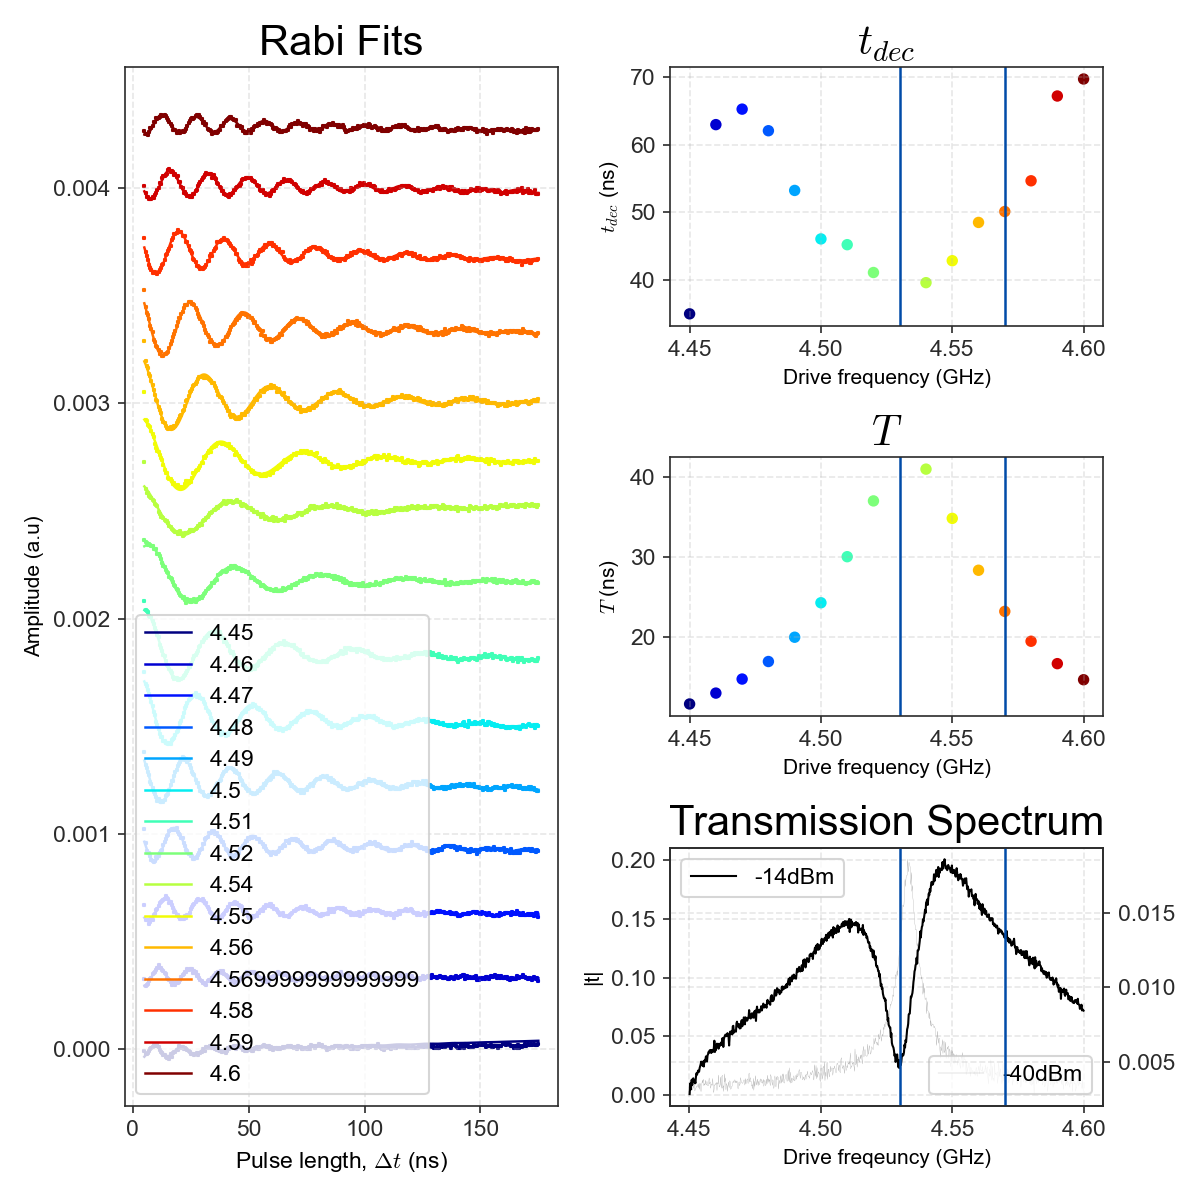

In [245]:
# Summarise the fittings:
SPACING = 0.0003
cmap = plt.cm.jet(np.linspace(0, 1, len(fit_data)))
fit_data = dict(sorted(fit_data.items()))

# Plot T, t_dec for different frequencies and the rabi plots
# fix, ax = plt.subplots(3, 1, figsize=(4,9))
plt.figure(figsize=(8, 8))
gs = gridspec.GridSpec(3, 2)

ax0 = plt.subplot(gs[:, 0])
ax0.set_title("Rabi Fits")
ax0.set_xlabel("Pulse length, $\Delta t$ (ns)", fontsize=11)
ax0.set_ylabel("Amplitude (a.u)", fontsize=10)

ax1 = plt.subplot(gs[0, 1])
ax1.set_title("$t_{dec}$")
ax1.set_xlabel(f"{VARIABLE}", fontsize=10)
ax1.set_ylabel("$t_{dec}$ (ns)", fontsize=10)

ax2 = plt.subplot(gs[1, 1])
ax2.set_title("$T$")
ax2.set_xlabel(f"{VARIABLE}", fontsize=10)
ax2.set_ylabel("$T$ (ns)", fontsize=10)

# Plot Rabi
for i, (idx, val) in enumerate(fit_data.items()):
    ax0.plot(T_DATA, i * SPACING + rabi_model(T_DATA, *val), color=cmap[i], label=F_DATA[idx])
    ax0.scatter(T_DATA, i * SPACING + DATA[idx], marker=',', color=cmap[i], s=1)
    
# Plot t_dec and T
unpacked_fit_data = np.array([[F_DATA[k], v[0], v[1]] for k, v in fit_data.items()])
unpacked_f = unpacked_fit_data[:, 0]
ax1.scatter(unpacked_f, unpacked_fit_data[:, 1], marker='o', s=20, color=cmap) 
ax2.scatter(unpacked_f, unpacked_fit_data[:, 2], marker='o', s=20, color=cmap) 

# Plot transmission
ax3 = plt.subplot(gs[2, 1])
ax3.set_title("Transmission Spectrum")
ax3.set_xlabel(f"Drive freqeuncy (GHz)", fontsize=10)
ax3.set_ylabel("|t|", fontsize=10)

transmission = np.loadtxt("C:/ExperimentBlue/2021-05_photon-source/20_spectrum_-40dBm.txt", skiprows=1)
selection_mask = np.logical_and(transmission[:, 0] > (unpacked_f[0] * GHz), transmission[:, 0] < unpacked_f[-1] * GHz)
ax3.plot(transmission[:, 0][selection_mask] / GHz, transmission[:, 1][selection_mask], linewidth=0.1, color='gray', label="-40dBm")
ax3.legend()

ax32 = ax3.twinx() 
transmission = np.loadtxt("C:/ExperimentBlue/2021-05_photon-source/20_spectrum_-14dBm.txt", skiprows=1)
selection_mask = np.logical_and(transmission[:, 0] > (unpacked_f[0] * GHz), transmission[:, 0] < unpacked_f[-1] * GHz)
ax32.plot(transmission[:, 0][selection_mask] / GHz, transmission[:, 1][selection_mask], linewidth=1, color='black', label="-14dBm")
ax32.axvline(4.53)
ax1.axvline(4.53)
ax2.axvline(4.53)

ax32.axvline(4.57)
ax1.axvline(4.57)
ax2.axvline(4.57)

ax32.legend(loc='upper left')
ax3.legend(loc='lower right')
ax0.legend()
plt.tight_layout()
plt.savefig(FILENAME.replace("txt", "svg"))

# T1 with VNA

# T1 with digitiser